In [1]:
import pandas as pd
import numpy as np
from pymoo.util.remote import Remote

In [4]:
file = Remote.get_instance().load("examples","portfolio_allocation.csv", to = None)
df = pd.read_csv(file, parse_dates=True,index_col='date')

In [7]:
returns = df.pct_change().dropna(how = 'all')

mu = (1+returns).prod() ** (252/returns.count()) - 1
cov = returns.cov()*252

mu, cov = mu.to_numpy(), cov.to_numpy()

In [16]:
labels = df.columns

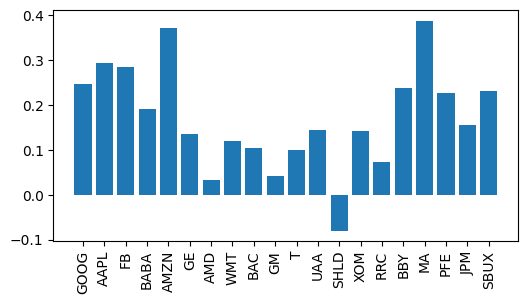

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (6,3))
k = np.arange(len(mu))
ax.bar(k,mu)
ax.set_xticks(k,labels,rotation = 90)
plt.show()


Text(0.5, 1.0, 'Correlation matrix')

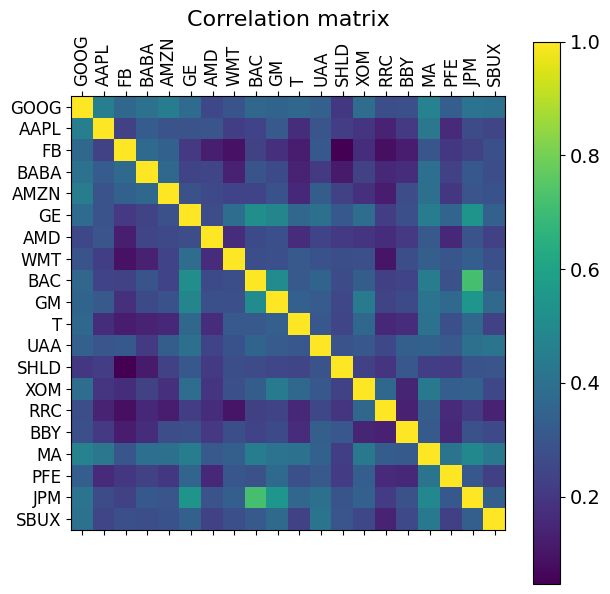

In [24]:

f = plt.figure(figsize=(7,7))
plt.matshow(returns.corr(), fignum = f.number)
plt.xticks(k, labels, fontsize = 12, rotation = 90)
plt.yticks(k, labels, fontsize = 12)
cb = plt.colorbar()
cb.ax.tick_params(labelsize = 14)
plt.title('Correlation matrix', fontsize = 16)

In [30]:
from pymoo.core.problem import ElementwiseProblem

class portfolio_problem(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate = 0.02, **kwargs):
        super().__init__(n_var = len(df.columns),
                         n_obj = 2,
                         xl = 0.0,
                         xu = 1.0,
                         **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu
        exp_risk = np.sqrt(x.T @ self.cov @ x)
        sharpe = (exp_return - self.risk_free_rate)/ exp_risk
        
        out["F"]= [exp_risk, -exp_return]
        out["sharpe"] = sharpe
        return super()._evaluate(x, out, *args, **kwargs)

In [31]:
from pymoo.core.repair import Repair

class portfolio_repair(Repair):
    
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0
        return X / X.sum(axis = 1, keepdims = True)

In [33]:
from pymoo.algorithms.moo.sms import SMSEMOA
from pymoo.optimize import minimize

problem = portfolio_problem(mu, cov)

algorithm = SMSEMOA(repair = portfolio_repair())

res = minimize(problem,
               algorithm,
               seed = 1,
               verbose = False)

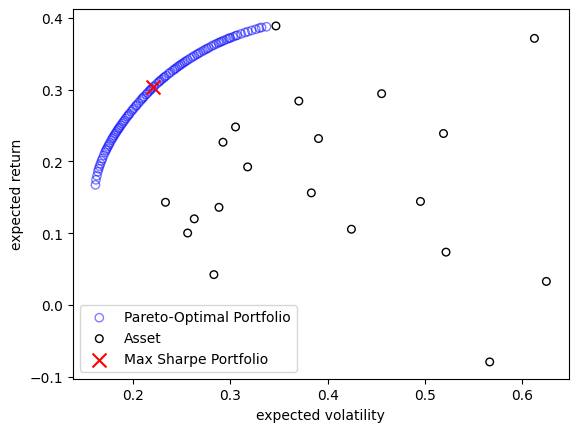

In [34]:
X, F, sharpe = res.opt.get("X", "F", "sharpe")
F = F * [1, -1]
max_sharpe = sharpe.argmax()

plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
plt.legend()
plt.xlabel("expected volatility")
plt.ylabel("expected return")
plt.show()

In [35]:
import operator

allocation = {name: w for name, w in zip(df.columns, X[max_sharpe])}
allocation = sorted(allocation.items(), key=operator.itemgetter(1), reverse=True)

print("Allocation With Best Sharpe")
for name, w in allocation:
    print(f"{name:<5} {w}")

Allocation With Best Sharpe
MA    0.34786344517867085
FB    0.19905525526583154
PFE   0.1927245208386189
BABA  0.07844688098284301
AAPL  0.06914179668856123
GOOG  0.05084214022348046
AMZN  0.0396794474637162
SBUX  0.01325713907916152
BBY   0.00898937427911626
GE    0.0
AMD   0.0
WMT   0.0
BAC   0.0
GM    0.0
T     0.0
UAA   0.0
SHLD  0.0
XOM   0.0
RRC   0.0
JPM   0.0
